In [1]:
# installing libraries:
! pip install pandas h3 ydata_profiling -q
import ydata_profiling
import pandas as pd 
import h3 


[notice] A new release of pip is available: 24.1.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
#import data
import pandas as pd
url_1 = 'https://raw.githubusercontent.com/woltapp/applied-science-internship-2026/refs/heads/main/orders_spring_2022.csv'
df = pd.read_csv(url_1)

In [3]:
#check NAs
df.isna().sum() 

order_placed_at_utc                        0
order_category                             0
item_count                                 0
actual_delivery_time_minutes               0
estimated_delivery_time_lower_minutes     56
estimated_delivery_time_upper_minutes     56
venue_location_h3_index                    0
customer_location_h3_index                 0
courier_supply_index                      98
precipitation                            870
dtype: int64

In [4]:
#remove NAs
cols_to_fix = [
    'estimated_delivery_time_lower_minutes', 
    'estimated_delivery_time_upper_minutes', 
    'courier_supply_index', 
    'precipitation'
]

def fill_missing_with_mean(df, columns):
    df = df.copy()
    for col in columns:
        column_mean = df[col].mean()
        df[col] = df[col].fillna(column_mean) 
    return df

df = fill_missing_with_mean(df, cols_to_fix)

In [5]:
#Fixing datetime:
df['date'] = pd.to_datetime(df['order_placed_at_utc'], utc = True)

In [6]:
#Estimated Time of Arrival:
times = ['estimated_delivery_time_lower_minutes','estimated_delivery_time_upper_minutes']
Adt = 'actual_delivery_time_minutes'
def status(df, columns, actual):
    for col in columns + [actual]:
        if col not in df.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame!")

    df['avg_estimate'] = df[columns].mean(axis=1)
    
    df['bias'] = df[actual] - df['avg_estimate']
    
    df['status'] = df['bias'].apply(lambda x: 'Late' if x > 0 else 'On Time')
    cat = pd.api.types.CategoricalDtype( categories = df['status'].unique())
    df['status'] = df['status'].astype(cat)
    
    return df

df = status(df, times, Adt)

In [7]:
#Time separated variables:
df['order_placed_at_utc'] = pd.to_datetime(df['order_placed_at_utc'], utc=True)
df['hour'] = df['order_placed_at_utc'].dt.hour
df['dayofweek'] = df['order_placed_at_utc'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6])
df['is_peak'] = ((df['hour'] >= 11) & (df['hour'] <= 13)) | ((df['hour'] >= 17) & (df['hour'] <= 20))
df['is_peak'] = df['is_peak']
df['day'] = df['order_placed_at_utc'].dt.date

In [8]:
#Little bit work on h3 data:
import numpy as np
np_vect = np.vectorize(h3.grid_distance)
# Call it directly on the columns
df['distance'] = np_vect(df['venue_location_h3_index'], df['customer_location_h3_index'])

In [9]:
df['csi_bin'] = pd.cut(df['courier_supply_index'], bins = 4)
cat = pd.api.types.CategoricalDtype(categories = df['order_category'].unique())
df['csi_cat'] = df['csi_bin'].astype('category').cat.codes
df['order_category'] = df['order_category'].astype(cat)


[notice] A new release of pip is available: 24.1.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


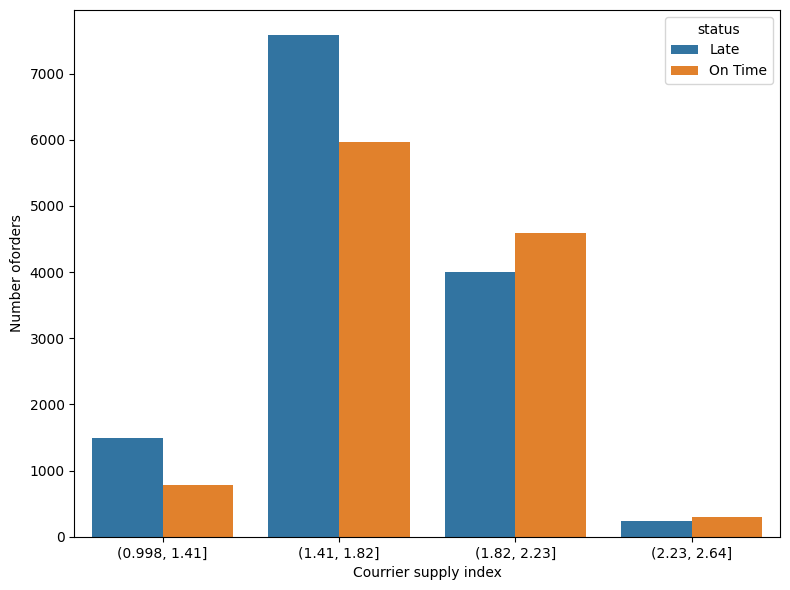

In [11]:
#plot from seaborn
!pip install seaborn matplotlib -q
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
cat1 = pd.api.types.CategoricalDtype(categories = df['csi_bin'].unique())
    
df['csi_cat'] = df['csi_bin'].astype(cat1)

sns.countplot(
    data=df,
    x='csi_cat',
    hue='status',
    # palette=['grey', 'green', 'red', 'yellow']
)

plt.ylabel('Number oforders')
plt.xlabel('Courrier supply index')
plt.tight_layout()
plt.savefig('CSI_vs_Satus.png', dpi = 300)
plt.show()

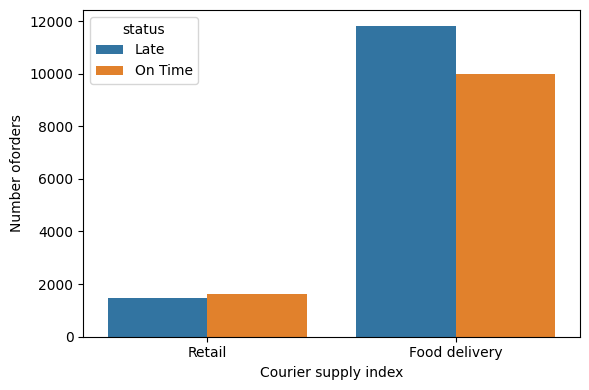

In [13]:
#Plotting delivery status in retail vs food

plt.figure(figsize=(6, 4))

sns.countplot(
    data=df,
    x='order_category',
    hue='status',
    # palette=['grey', 'green', 'red', 'yellow']
)

plt.ylabel('Number oforders')
plt.xlabel('Courier supply index')
plt.tight_layout()
plt.savefig('Status_vs_OrderType.png', dpi = 300)
plt.show()

In [14]:
#importing statistical packages
!pip install statsmodels ISLP -q
import statsmodels.api as sm


[notice] A new release of pip is available: 24.1.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [16]:
# df['csi_binary'] = (df['courier_supply_index'] > 1.82).astype(int)
# # Check distribution
# df['csi_binary'].value_counts()

csi_binary
0    15815
1     9127
Name: count, dtype: int64

In [32]:
#Computing statistical model
import statsmodels.formula.api as smf

result = smf.logit(
    'csi_binary ~ item_count + precipitation + hour + distance + is_peak + is_weekend + bias',
    data=df
).fit()


Optimization terminated successfully.
         Current function value: 0.596319
         Iterations 7


In [33]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:             csi_binary   No. Observations:                24942
Model:                          Logit   Df Residuals:                    24934
Method:                           MLE   Df Model:                            7
Date:                Sun, 08 Feb 2026   Pseudo R-squ.:                 0.09202
Time:                        09:16:53   Log-Likelihood:                -14873.
converged:                       True   LL-Null:                       -16381.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.4981      0.055    -27.084      0.000      -1.607      -1.390
is_peak[T.True]       -1.5962      0.033    -47.982      0.000      -1.661      -1.531
is_weekend[T.True]  

In [42]:
#Converting status into binary
df['status_binary'] = (df['status'] == 'On Time').astype(int)

# Check distribution
df['status_binary'].value_counts()

status_binary
0    13308
1    11634
Name: count, dtype: int64

In [43]:
X = df[['item_count', 'precipitation', 'hour', 'distance',
        'is_peak', 'is_weekend', ]]
y = df['status_binary']

In [62]:
from sklearn.preprocessing import StandardScaler,RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_features = ['item_count', 'precipitation', 'hour', 'distance', 'is_peak', 'is_weekend']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ]
)

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced'  # handles imbalance
    ))
])


In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # ensures class balance in train/test
)

In [65]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Train
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # probability for class 1

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.5229504910803768
ROC AUC: 0.5365060051910784

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.47      0.51      2662
           1       0.49      0.58      0.53      2327

    accuracy                           0.52      4989
   macro avg       0.53      0.53      0.52      4989
weighted avg       0.53      0.52      0.52      4989


Confusion Matrix:
 [[1257 1405]
 [ 975 1352]]
